In [10]:
from glob import glob
import sys
import pickle

import pandas as pd
from scipy.io import arff
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split


# Prepare Data

## Import

we need to begin by bringing our data into the project

In [2]:

# Loads the 5 raw .arff files into pandas dataframes
def load_dataframes(p):
    paths = glob(p)
    data =  [arff.loadarff(p) for p in paths]
    return    [pd.DataFrame(d[0]) for d in data]


############################################################
# Set the column headers from feat_1 ... feat_64 and the class label as bankrupty, for all the 5 dataframes.
def set_new_headers(dataframes):
    cols = ['feat_' + str(i+1) for i in range(len(dataframes[0].columns)-1)]
    cols.append('bankrupt')
    for df in dataframes:
        df.columns = cols

############################################################
# dataframes is the list of pandas dataframes for the 5 year datafiles.  
#dataframes = load_dataframes()

# Set the new headers for the dataframes. The new headers will have the renamed set of feature (X1 to X64)
#set_new_headers(dataframes)    
############################################################

# Convert the dtypes of all the columns (other than the class label columns) to float.
def convert_columns_type_float(dfs):
    for i in range(5):
        index = 1
        while(index<=63):
            colname = dfs[i].columns[index]
            col = getattr(dfs[i], colname)
            dfs[i][colname] = col.astype(float)
            index+=1
            
#convert_columns_type_float(dataframes)
############################################################

# The class labels for all the dataframes are originally in object type.
# Convert them to int types
def convert_class_label_type_int(dfs):
    for i in range(len(dfs)):
        col = getattr(dfs[i], 'bankrupt')
        dfs[i]['bankrupt'] = col.astype(int)
        
#convert_class_label_type_int(dataframes)
############################################################
def wrangle(path):
    dataframes = load_dataframes(p=path)
    set_new_headers(dataframes)    
    convert_columns_type_float(dataframes)
    convert_columns_type_float(dataframes)
    convert_class_label_type_int(dataframes)
    df = pd.concat(dataframes) #.dropna(inplace=True)
    df["company_id"] = range(len(df))
    df.set_index("company_id" , inplace=True)
    return df

In [3]:
df = wrangle(path="/home/jumaa/PROJECT/Python/050bankrupty_in_poland/polish-companies-bankruptcy-data/*year.arff")
print(df.shape)
print(df.info())
df.head()

(43405, 65)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 43405 entries, 0 to 43404
Data columns (total 65 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   feat_1    43397 non-null  float64
 1   feat_2    43397 non-null  float64
 2   feat_3    43397 non-null  float64
 3   feat_4    43271 non-null  float64
 4   feat_5    43316 non-null  float64
 5   feat_6    43397 non-null  float64
 6   feat_7    43397 non-null  float64
 7   feat_8    43311 non-null  float64
 8   feat_9    43396 non-null  float64
 9   feat_10   43397 non-null  float64
 10  feat_11   43361 non-null  float64
 11  feat_12   43271 non-null  float64
 12  feat_13   43278 non-null  float64
 13  feat_14   43397 non-null  float64
 14  feat_15   43369 non-null  float64
 15  feat_16   43310 non-null  float64
 16  feat_17   43311 non-null  float64
 17  feat_18   43397 non-null  float64
 18  feat_19   43277 non-null  float64
 19  feat_20   43278 non-null  float64
 20  feat_21   37551 

,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64,bankrupt
company_id,,,,,,,,,,,,,,,,,,,,,
0,0.088238,0.55472,0.01134,1.0205,-66.5200,0.342040,0.109490,0.57752,1.0881,0.32036,...,0.080955,0.275430,0.91905,0.002024,7.2711,4.7343,142.760,2.5568,3.2597,0
1,-0.006202,0.48465,0.23298,1.5998,6.1825,0.000000,-0.006202,1.06340,1.2757,0.51535,...,-0.028591,-0.012035,1.00470,0.152220,6.0911,3.2749,111.140,3.2841,3.3700,0
2,0.130240,0.22142,0.57751,3.6082,120.0400,0.187640,0.162120,3.05900,1.1415,0.67731,...,0.123960,0.192290,0.87604,0.000000,8.7934,2.9870,71.531,5.1027,5.6188,0
3,-0.089951,0.88700,0.26927,1.5222,-55.9920,-0.073957,-0.089951,0.12740,1.2754,0.11300,...,0.418840,-0.796020,0.59074,2.878700,7.6524,3.3302,147.560,2.4735,5.9299,0
4,0.048179,0.55041,0.10765,1.2437,-22.9590,0.000000,0.059280,0.81682,1.5150,0.44959,...,0.240400,0.107160,0.77048,0.139380,10.1180,4.0950,106.430,3.4294,3.3622,0


## Explore

Let's take a moment to refresh our memory on what's in this dataset.

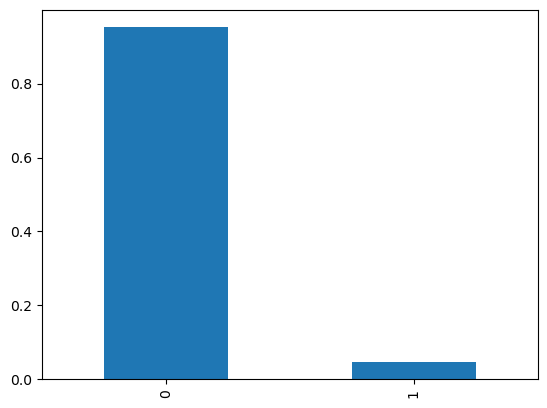

In [4]:
df["bankrupt"].value_counts(normalize=True).plot(kind="bar");

It shows us that we have an imbalanced dataset, where our majority class is far bigger than our minority class.

## Split

In [5]:
target = "bankrupt"
X = df.drop(columns=target)
y = df[target]

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (43405, 64)
y shape: (43405,)


Since we're not working with time series data, we're going to randomly divide our dataset into training and test sets 

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X , y, test_size=0.2 , random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (34724, 64)
y_train shape: (34724,)
X_test shape: (8681, 64)
y_test shape: (8681,)


## Resample

In [7]:
X_train_over, y_train_over = RandomOverSampler(random_state=42).fit_resample(X_train , y_train)
print("X_train_over shape:", X_train_over.shape)
X_train_over.head()

X_train_over shape: (66088, 64)


,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_55,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64
0,0.09917,0.53416,-0.115670,0.59737,-171.500,0.12832,0.099759,0.40877,1.17820,0.21835,...,-4763.40000,0.151260,0.454180,0.84874,1.130600,5.5544,17.6530,150.240,2.42940,0.84254
1,-0.21799,1.19870,-0.117230,0.88859,-398.940,-0.10353,-0.217990,-0.16573,0.65402,-0.19866,...,-1730.10000,-0.055770,1.097300,1.32920,-0.737150,1.0386,2.1889,587.220,0.62157,10.06000
2,-0.01236,0.44718,0.157150,1.36550,-15.911,0.14693,-0.012360,1.12000,0.99133,0.50085,...,3013.90000,-0.008746,-0.024677,1.00870,0.034357,8.8255,6.5769,71.255,5.12250,5.33470
3,0.14592,0.36115,-0.004687,0.98252,-106.530,0.00000,0.153880,1.76890,0.60365,0.63885,...,0.98252,0.270750,0.228410,0.61258,0.145590,7.0031,4.1734,162.130,2.25120,0.81957
4,0.33202,0.72093,0.078647,1.11050,20.973,0.48570,0.411520,0.38709,1.36400,0.27907,...,1903.30000,0.266870,1.189700,0.73313,0.032695,167.0300,2.0608,163.730,2.22930,7.57270


# Build Model

Now that we have our data set up the right way, we can build the model.

## Baseline

In [8]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 4))

Baseline Accuracy: 0.9516


## Iterate

In [11]:
clf = make_pipeline(
    SimpleImputer(),
    RandomForestClassifier(random_state=42)
)
clf

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

In [12]:
params = {
    "simpleimputer__strategy": ["mean" , "median"],
    "randomforestclassifier__n_estimators": range(25,100,25),
    "randomforestclassifier__max_depth": range(10,50,10)
}
params

{'simpleimputer__strategy': ['mean', 'median'],
 'randomforestclassifier__n_estimators': range(25, 100, 25),
 'randomforestclassifier__max_depth': range(10, 50, 10)}

In [13]:
model = GridSearchCV(
    clf,
    param_grid=params,
    cv=5,
    n_jobs=-1,
    verbose=1
)
model

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(10, 50, 10),
                         'randomforestclassifier__n_estimators': range(25, 100, 25),
                         'simpleimputer__strategy': ['mean', 'median']},
             verbose=1)

In [14]:
# Train model
model.fit(X_train_over , y_train_over)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(10, 50, 10),
                         'randomforestclassifier__n_estimators': range(25, 100, 25),
                         'simpleimputer__strategy': ['mean', 'median']},
             verbose=1)

that makes 24 forests. How many fits did we just do? 24 forests times 5 folds is 120. And remember that each forest is comprised of 25-75 trees, which works out to at least 3,000 trees.

Okay, now let's take a look at the results.

In [15]:
cv_results = pd.DataFrame(model.cv_results_).sort_values(by="rank_test_score" ,ascending=True)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__max_depth,param_randomforestclassifier__n_estimators,param_simpleimputer__strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
21,39.869526,2.770637,0.332459,0.140423,40,50,median,"{'randomforestclassifier__max_depth': 40, 'ran...",0.996671,0.998109,0.998033,0.997276,0.997125,0.997443,0.000551,1
20,39.731801,1.377897,0.353975,0.077443,40,50,mean,"{'randomforestclassifier__max_depth': 40, 'ran...",0.996823,0.998260,0.997806,0.997352,0.996974,0.997443,0.000532,2
22,50.562579,1.216443,0.402956,0.050350,40,75,mean,"{'randomforestclassifier__max_depth': 40, 'ran...",0.996520,0.998336,0.997806,0.997503,0.996822,0.997397,0.000657,3
23,47.273745,5.746787,0.330185,0.063385,40,75,median,"{'randomforestclassifier__max_depth': 40, 'ran...",0.996520,0.998260,0.997882,0.996974,0.997125,0.997352,0.000631,4
16,51.360633,1.294133,0.400177,0.012753,30,75,mean,"{'randomforestclassifier__max_depth': 30, 'ran...",0.996066,0.997806,0.997957,0.997503,0.996822,0.997231,0.000701,5


In [16]:
# Extract best hyperparameters
model.best_params_

{'randomforestclassifier__max_depth': 40,
 'randomforestclassifier__n_estimators': 50,
 'simpleimputer__strategy': 'median'}

## Evaluate

In [17]:
acc_train = model.score(X_train_over , y_train_over)
acc_test = model.score(X_test , y_test)

print("Training Accuracy:", round(acc_train, 4))
print("Test Accuracy:", round(acc_test, 4))

Training Accuracy: 1.0
Test Accuracy: 0.9635


In [18]:
y_test.value_counts()

0    8270
1     411
Name: bankrupt, dtype: int64

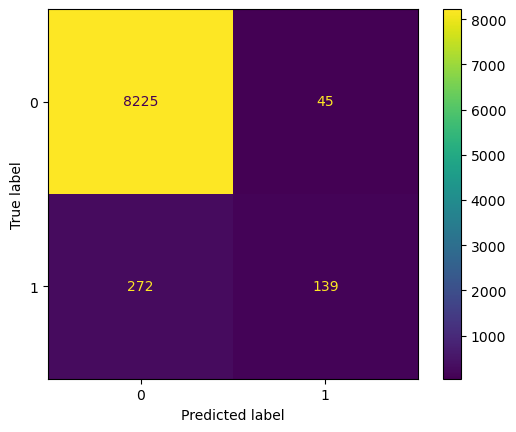

In [19]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(model , X_test , y_test);

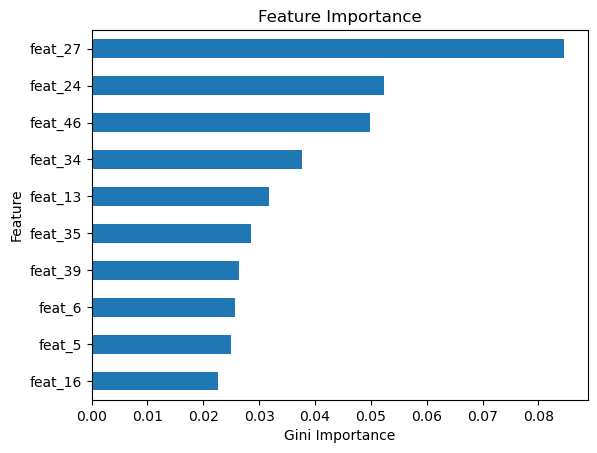

In [20]:
# Get feature names from training data
features = X_train_over.columns
# Extract importances from model
importances = model.best_estimator_.named_steps["randomforestclassifier"].feature_importances_
# Create a series with feature names and importances
feat_imp = pd.Series(importances , index=features).sort_values()
# Plot 10 most important features
feat_imp.tail(10).plot(kind="barh")
plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.title("Feature Importance");